In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
#%% obs grid
Nx, Ny = 30, 30
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 10
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [6]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [7]:
truepsffunc = gaussian_psf

In [8]:
xcenters = np.array([15., 24.2, 5.4, 7.3])
ycenters = np.array([19.2, 5.5, 6.0, 22.])
sigma = 1.
truepsfkws = {"sigma": 1}

In [9]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [10]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

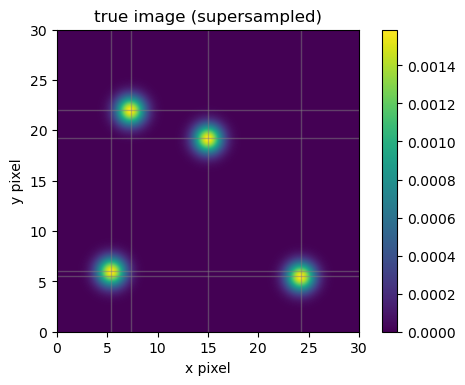

In [11]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

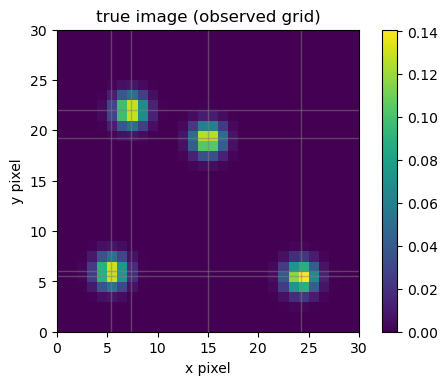

In [12]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [13]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

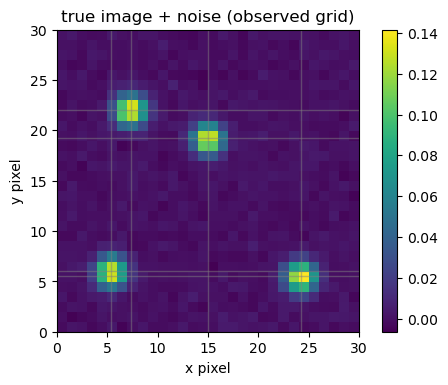

In [14]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [15]:
# define supersampled ePSF
xext, yext = 7., 7.
dx, dy = 1./2., 1./2.
#xext, yext = 5., 5.
#dx, dy = 0.6, 0.6
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)

PSF grid shape: (15, 15)


In [16]:
from tinygp import kernels, GaussianProcess
def gpmodel(Z, sigmaerr, gpsf, xcenters, ycenters):
    ones = jnp.ones_like(xcenters)
    
    c = numpyro.sample("c", dist.TruncatedNormal(loc=ones, scale=ones, low=ones*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-3, high=xcenters[1:]+3))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-3, high=ycenters[1:]+3))
    xc = jnp.r_[xcenters[0], x]
    yc = jnp.r_[ycenters[0], y]

    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=3))
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=3))
    lna = numpyro.sample("lna", dist.Uniform(low=-2, high=5))
    lnsigma = numpyro.sample("lnsigma", dist.Uniform(-10, -5))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    kernel = kernels.ExpSquared(jnp.array([lenx, leny]))
    kernel = jnp.exp(2*lna) * kernel
    X = jnp.array([gpsf.X1d, gpsf.Y1d]).T
    gp = GaussianProcess(kernel, X, diag=jnp.exp(2*lnsigma), mean=0.)
    alphas = numpyro.sample("alphas", gp.numpyro_dist())

    Zpsf_model = gpsfvalues(spix.X, spix.Y, xc, yc, jnp.exp(alphas)) 
    Zpsf_model = jnp.sum(Zpsf_model / jnp.sum(Zpsf_model, axis=(1,2))[:,None, None] * c[:,None,None], axis=0)
    Zpsf_obs = numpyro.deterministic("Zpsf_obs", super_to_obs(Zpsf_model))

    numpyro.sample("obs", dist.Normal(Zpsf_obs, sigmaerr), obs=Z)

In [17]:
kernel = numpyro.infer.NUTS(gpmodel)

In [18]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [19]:
rng_key = random.PRNGKey(0)

In [20]:
mcmc.run(rng_key, Zobs, sigmaerr, gpsf, xcenters, ycenters)

  0%|                                                                                                    | 0/1000 [00:00<?, ?it/s]/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
sample: 100%|██████████████████████████████████| 1000/1000 [3:56:57<00:00, 14.22s/it, 1023 steps of size 4.78e-03. acc. prob=0.60]


In [21]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  alphas[0]     -7.21      0.67     -7.25     -8.39     -6.16     39.02      1.01
  alphas[1]     -5.91      0.52     -5.93     -6.64     -4.98     40.00      1.02
  alphas[2]     -4.79      0.42     -4.78     -5.32     -4.04     40.53      1.03
  alphas[3]     -3.84      0.35     -3.84     -4.40     -3.33     40.52      1.05
  alphas[4]     -3.09      0.30     -3.10     -3.55     -2.63     40.12      1.07
  alphas[5]     -2.55      0.27     -2.55     -2.96     -2.14     39.84      1.08
  alphas[6]     -2.21      0.26     -2.20     -2.64     -1.89     39.82      1.08
  alphas[7]     -2.08      0.25     -2.08     -2.46     -1.73     42.26      1.07
  alphas[8]     -2.18      0.26     -2.19     -2.60     -1.83     46.59      1.06
  alphas[9]     -2.49      0.27     -2.51     -2.91     -2.04     49.93      1.03
 alphas[10]     -3.02      0.31     -3.03     -3.56     -2.57     47.29      1.01
 alphas[11]    

In [22]:
smp = mcmc.get_samples()

In [23]:
mean_model = np.mean(smp["Zpsf_obs"], axis=0)

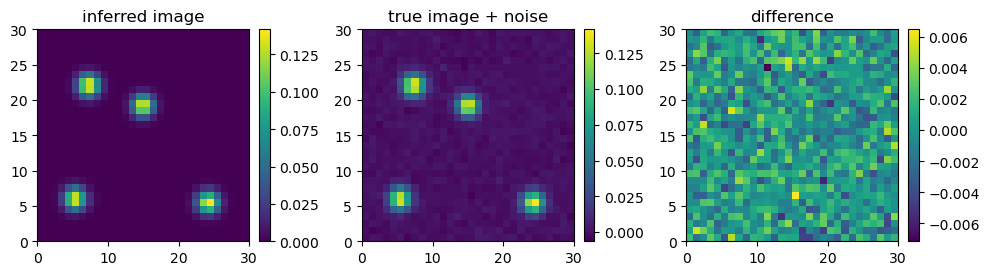

In [36]:
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([mean_model, Zobs, mean_model-Zobs], 
                                     ['inferred image', 'true image + noise', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

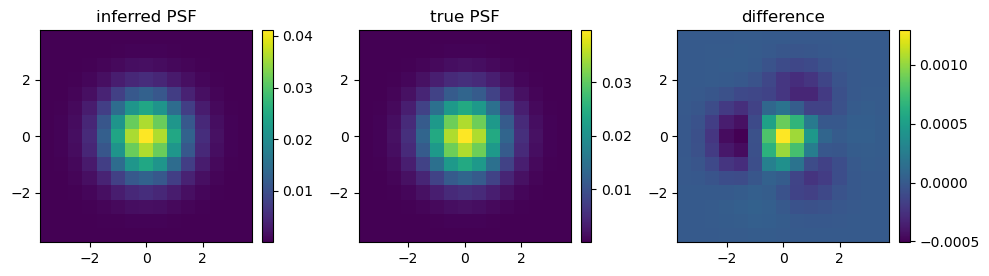

In [32]:
Xg, Yg = np.meshgrid(gpsf.xgrid_center, gpsf.ygrid_center)
pmean = np.exp(np.mean(smp['alphas'], axis=0))
meanpsf = gpsf.psfvalues(Xg, Yg, 0, 0, pmean)
truepsf = truepsffunc(Xg, Yg, 0, 0, **truepsfkws)
meanpsf /= np.sum(meanpsf)
truepsf /= np.sum(truepsf)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([meanpsf, truepsf, meanpsf-truepsf], ['inferred PSF', 'true PSF', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=[gpsf.xgrid_edge[0], gpsf.xgrid_edge[-1], gpsf.ygrid_edge[0], gpsf.ygrid_edge[-1]])
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

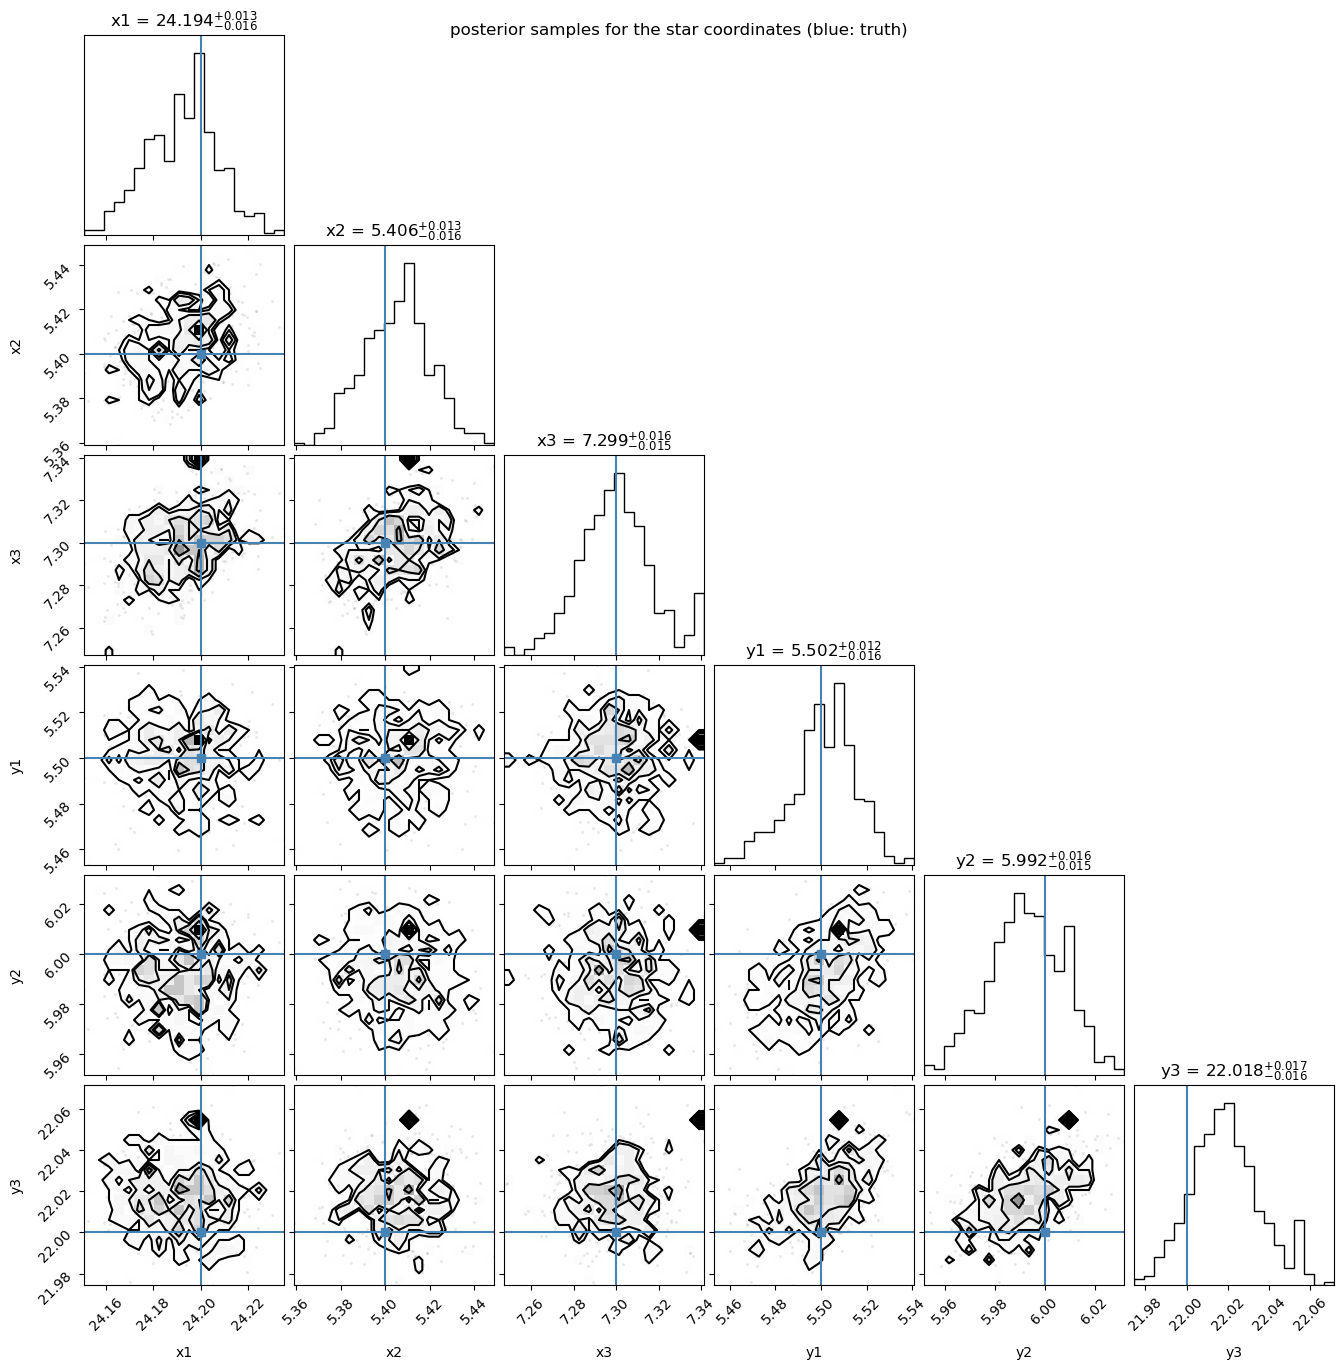

In [35]:
fig = corner.corner(np.c_[np.array(smp['x']), np.array(smp['y'])], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:], ycenters[1:]],
                   labels=["x%d"%i for i in range(1,len(xcenters))]+["y%d"%i for i in range(1,len(xcenters))])
fig.suptitle("posterior samples for the star coordinates (blue: truth)");